In [189]:
from google.colab import drive
drive.mount('/content/drive/')

%cd "/content/drive/My Drive/Cursos/Control Inteligente/"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/Cursos/Control Inteligente


In [0]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [0]:
u = pd.read_csv('u.csv', engine='python')
u_train = pd.read_csv('u_train.csv', engine='python')
u_test = pd.read_csv('u_test.csv', engine='python')
u_val = pd.read_csv('u_val.csv', engine='python')

y = pd.read_csv('y.csv', engine='python')
y_train = pd.read_csv('y_train.csv', engine='python')
y_test = pd.read_csv('y_test.csv', engine='python')
y_val = pd.read_csv('y_val.csv', engine='python')

In [0]:
# Train
l_train = len(u_train)
u1_train = u_train.values[1:l_train-1]        # u(k-1)
u2_train = u_train.values[0:l_train-2]        # u(k-2)
y1_train = y_train.values[1:l_train-1]        # y(k-1)
y2_train = y_train.values[0:l_train-2]        # y(k-2)
y_train = y_train.values[2:l_train]          # y(k), salida

x_train = np.transpose([y1_train, y2_train, u1_train, u2_train])

# Test
l_test = len(u_test)
u1_test = u_test.values[1:l_test-1]           # u(k-1)
u2_test = u_test.values[0:l_test-2]           # u(k-2)
y1_test = y_test.values[1:l_test-1]           # y(k-1)
y2_test = y_test.values[0:l_test-2]           # y(k-2)
y_test = y_test.values[2:l_test]             # y(k), salida

x_test = np.transpose([y1_test, y2_test, u1_test, u2_test])

# Val
l_val = len(u_val)
u1_val = u_val.values[1:l_val-1]              # u(k-1)
u2_val = u_val.values[0:l_val-2]              # u(k-2)
y1_val = y_val.values[1:l_val-1]              # y(k-1)
y2_val = y_val.values[0:l_val-2]              # y(k-2)
y_val = y_val.values[2:l_val]                 # y(k), salida

x_val = np.transpose([y1_val, y2_val, u1_val, u2_val])

In [0]:
# A torch.Tensor is a multi-dimensional matrix containing elements of a single data type.
# A tensor can be constructed from a Python list or sequence using the torch.tensor() constructor

X_train = torch.tensor(x_train, dtype=torch.float)
Y_train = torch.tensor(y_train, dtype=torch.float)
X_test = torch.tensor(x_test, dtype=torch.float)
Y_test = torch.tensor(y_test, dtype=torch.float)
X_val = torch.tensor(x_val, dtype=torch.float)
Y_val = torch.tensor(y_val, dtype=torch.float)

# Entrenamiento de la red optima obtenida en matlab

In [0]:
# Parametros del modelo

inp = 4       # Input layer
hid = 15      # Hidden layer
out = 1       # Output layer

loss_funct = torch.nn.MSELoss()
lr = 1e-1
epoch = 500

In [0]:
# Definir modelo

model = torch.nn.Sequential(torch.nn.Linear(inp, hid),
                            torch.nn.Sigmoid(),
                            torch.nn.Linear(hid, out))

In [218]:
for i in range(epoch):
  y_pred = model(X_train)
  loss = loss_funct(y_pred, Y_train)

  if i%10 == 0:
    print(i, loss.item())

  model.zero_grad()
  loss.backward()

  with torch.no_grad():
    for param in model.parameters():
      param -= lr*param.grad

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3297, 1])) that is different to the input size (torch.Size([1, 3297, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


0 1.2640184164047241
10 0.6635231971740723
20 0.477165549993515
30 0.4176348149776459
40 0.38546064496040344
50 0.3579346239566803
60 0.33180975914001465
70 0.3068958818912506
80 0.2834300994873047
90 0.2617095410823822
100 0.24200895428657532
110 0.22453266382217407
120 0.20938245952129364
130 0.19654501974582672
140 0.1859002262353897
150 0.17724549770355225
160 0.17032767832279205
170 0.16487495601177216
180 0.16062216460704803
190 0.15732818841934204
200 0.15478502213954926
210 0.15282033383846283
220 0.15129594504833221
230 0.1501036435365677
240 0.14916040003299713
250 0.14840340614318848
260 0.14778558909893036
270 0.1472720354795456
280 0.14683681726455688
290 0.1464608609676361
300 0.1461300253868103
310 0.14583396911621094
320 0.14556488394737244
330 0.14531704783439636
340 0.1450861245393753
350 0.14486894011497498
360 0.1446629911661148
370 0.14446641504764557
380 0.14427772164344788
390 0.14409583806991577
400 0.1439199000597
410 0.1437491774559021
420 0.14358311891555786


In [0]:
torch.save(model,'nn')
nn = torch.load('nn')

In [0]:
y_pred = nn(X_test)
y_pred = y_pred.detach().numpy()

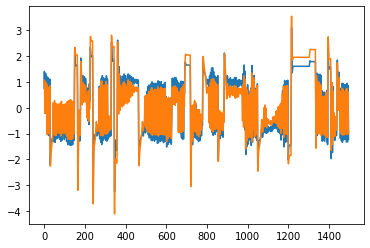

In [202]:
plt.plot(y_pred[0])
plt.plot(y_test)
plt.show()

# Joint Supervision

In [0]:
class Lu(torch.autograd.Function):
    @staticmethod
    def forward(ctx, y, y_pred):
        ctx.save_for_backward(y, y_pred)
        e = y_pred-y
        e[e<0] = 0 
        return l*e.pow(2).sum() + (y_pred-y).pow(2).sum()

    @staticmethod
    def backward(ctx, grad_output):
        yy, yy_pred = ctx.saved_tensors
        e = y_pred-y_pred
        e[e<0] = 0 
        grad_output = l*(-2 * e).sum() + 2*(y_pred-y).sum()
        return grad_output


class Ld(torch.autograd.Function):
    @staticmethod
    def forward(ctx, y, y_pred):
        ctx.save_for_backward(y, y_pred)
        e = y_pred-y
        e[e>0] = 0 
        return l*e.pow(2).sum() + (y_pred-y).pow(2).sum()

    @staticmethod
    def backward(ctx, grad_output):
        yy, yy_pred = ctx.saved_tensors
        e = y_pred-y_pred
        e[e>0] = 0 
        grad_output = l*(-2 * e).sum() + 2*(y_pred-y).sum()
        return grad_output


In [0]:
# Parametros del modelo

inp = 4       # Input layer
hid = 15      # Hidden layer
out = 3       # Output layer
l = 3         # Lambda

loss_or = torch.nn.MSELoss()
loss_upper = Ld()
loss_lower = Ld()
# loss_upper = torch.nn.MSELoss()
# loss_lower = torch.nn.MSELoss()

lr = 1e-2
epoch = 100

In [0]:
model_joint = torch.nn.Sequential(torch.nn.Linear(inp, hid),
                            torch.nn.Sigmoid(),
                            torch.nn.Linear(hid, out))

In [274]:
for i in range(epoch):
  y_pred = model_joint(X_train)
  loss0 = loss_upper.apply(y_pred[0][:,0], Y_train)
  loss1 = loss_or(y_pred[0][:,1], Y_train)
  loss2 = loss_lower.apply(y_pred[0][:,2], Y_train)

  loss = loss0+loss1+loss2

  if i%10 == 0:
    print(i, loss.item())

  model_joint.zero_grad()
  loss.backward()

  with torch.no_grad():
    for param in model_joint.parameters():
      param -= lr*param.grad

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3297, 1])) that is different to the input size (torch.Size([3297])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


0 51735456.0


RuntimeError: ignored